<a href="https://colab.research.google.com/github/weix20/Mobility-Data-Processing/blob/main/Analysis_of_U_S_Mobility_Patterns_and_Parallel_Processing_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BTS Trips Analysis (Serial vs Parallel) — Updated Notebook

This notebook implements all requirements (a–e) from the task brief:
- (a) staying home counts + how far people travel when they don't stay home
- (b) identify dates meeting thresholds for 10–25 and 50–100 trips
- (c) compare sequential vs parallel using 10 and 20 processors
- (d) build a model to simulate *travel frequency* while considering trip length
- (e) visualize *participants (travellers)* by distance–trips and discuss outcomes


In [1]:
import os
import time
import warnings
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Prefer joblib for parallelism; fall back if unavailable.
try:
    from joblib import Parallel, delayed
    _HAS_JOBLIB = True
except Exception:
    _HAS_JOBLIB = False

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)


## 0) Load data

Expected input files (same folder as this notebook):
- `Trips_by_Distance.csv`
- `Trips_Full Data.csv`



In [2]:
BIG_PATH_CANDIDATES = ["Trips_by_Distance.csv", os.path.join("data", "Trips_by_Distance.csv"), "/mnt/data/Trips_by_Distance.csv"]
SMALL_PATH_CANDIDATES = ["Trips_Full Data.csv", os.path.join("data", "Trips_Full Data.csv"), "/mnt/data/Trips_Full Data.csv"]

def load_first_existing(candidates: list[str]) -> str:
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(
        "Could not find the required CSV file. Tried:\n"
        + "\n".join(f"  - {p}" for p in candidates)
        + "\n\nPut the CSVs next to this notebook (or update the *_PATH_CANDIDATES lists)."
    )

big_path = load_first_existing(BIG_PATH_CANDIDATES)
small_path = load_first_existing(SMALL_PATH_CANDIDATES)

big_dataset = pd.read_csv(big_path)
small_dataset = pd.read_csv(small_path)

# Dates
big_dataset["Date"] = pd.to_datetime(big_dataset["Date"])
small_dataset["Date"] = pd.to_datetime(small_dataset["Date"])

print("Big dataset shape:", big_dataset.shape)
display(big_dataset.head())
print("Small dataset shape:", small_dataset.shape)
display(small_dataset.head())


Big dataset shape: (74896, 22)


,Level,Date,State FIPS,State Postal Code,County FIPS,County Name,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Row ID,Week,Month
0,National,2019-01-01,NaN,NaN,NaN,NaN,77433867.0,248733553.0,8.977844e+08,241667151.0,234284795.0,108078903.0,129670778.0,116904343.0,40432062.0,15686639.0,7525563.0,1806022.0,1728112.0,00-00000-20190101,0.0,1.0
1,National,2019-01-02,NaN,NaN,NaN,NaN,61305201.0,264862219.0,1.139452e+09,291276735.0,285887315.0,138039296.0,171637514.0,167412698.0,56148976.0,17739183.0,7817044.0,1962301.0,1531219.0,00-00000-20190102,0.0,1.0
2,National,2019-01-03,NaN,NaN,NaN,NaN,63050480.0,263116940.0,1.162753e+09,296375014.0,290074425.0,140771581.0,175775410.0,172027487.0,57632422.0,18366626.0,8124548.0,2038099.0,1567072.0,00-00000-20190103,0.0,1.0
3,National,2019-01-04,NaN,NaN,NaN,NaN,61803652.0,264363768.0,1.181954e+09,293159631.0,295643296.0,145251819.0,181324645.0,176144493.0,58761592.0,19315785.0,8687318.0,2096065.0,1569185.0,00-00000-20190104,0.0,1.0
4,National,2019-01-05,NaN,NaN,NaN,NaN,64389745.0,261777675.0,1.180477e+09,295459014.0,304168709.0,148540651.0,180941769.0,165239790.0,54842134.0,19363939.0,8490791.0,1991159.0,1438664.0,00-00000-20190105,0.0,1.0


Small dataset shape: (7, 22)


,Month of Date,Week of Date,Year of Date,Level,Date,Week Ending Date,Trips <1 Mile,People Not Staying at Home,Population Staying at Home,Trips,Trips 1-25 Miles,Trips 1-3 Miles,Trips 10-25 Miles,Trips 100-250 Miles,Trips 100+ Miles,Trips 25-100 Miles,Trips 25-50 Miles,Trips 250-500 Miles,Trips 3-5 Miles,Trips 5-10 Miles,Trips 50-100 Miles,Trips 500+ Miles
0,August,Week 32,2019,National,2019-08-04,10-Aug-19,292959749,258404133,67763287,1322685497,934957837,346577279,200922270,8595827,15338786,79429125,59517188,2273613,171336406,216121882,19911937,4469346
1,August,Week 32,2019,National,2019-08-05,10-Aug-19,317133861,262199758,63967662,1412564488,996863262,358008909,228809869,6535920,12563068,86004297,68184743,1941260,178996059,231048425,17819554,4085888
2,August,Week 32,2019,National,2019-08-06,10-Aug-19,324443205,260096133,66071287,1437762102,1014614495,366533991,235621127,5993704,11104823,87599579,70149166,1741994,179210645,233248732,17450413,3369125
3,August,Week 32,2019,National,2019-08-07,10-Aug-19,358483024,258878802,67288618,1543710309,1084498325,401474049,249988663,5379881,8528574,92200386,74381367,1272248,189163336,243872277,17819019,1876445
4,August,Week 32,2019,National,2019-08-08,10-Aug-19,300765870,262410045,63757375,1382044815,984193010,347857770,226055368,6259735,12892348,84193587,66724543,1957888,179346163,230933709,17469044,4674725


## 1) Inspect data structure

This step provides an overview of the loaded datasets.  
It displays each column name, the number of non-missing values, and the data type, allowing us to verify that the data is complete and correctly formatted.  
A summary of missing values is also included to highlight any fields that may require cleaning before further analysis.


In [10]:
# =======================
#  Data Structure Inspection
# =======================

print("=== Big Dataset Structure ===")
big_info_df = pd.DataFrame({
    'Column': big_dataset.columns,
    'Non-Null Count': [big_dataset[col].notna().sum() for col in big_dataset.columns],
    'Dtype': big_dataset.dtypes.values
})
display(big_info_df)

print("\n=== Small Dataset Structure ===")
small_info_df = pd.DataFrame({
    'Column': small_dataset.columns,
    'Non-Null Count': [small_dataset[col].notna().sum() for col in small_dataset.columns],
    'Dtype': small_dataset.dtypes.values
})
display(small_info_df)

# =======================
# Missing Value Inspection
# =======================
missing_big = big_dataset.isnull().sum()
missing_small = small_dataset.isnull().sum()

print("\n=== Missing Value Summary (Only columns with missing values) ===")
missing_df = pd.DataFrame({
    'Big Dataset Missing': missing_big[missing_big > 0],
    'Small Dataset Missing': missing_small[missing_small > 0]
})
display(missing_df)


=== Big Dataset Structure ===


,Column,Non-Null Count,Dtype
0,Level,74896,object
1,Date,74896,datetime64[ns]
2,State FIPS,74009,float64
3,State Postal Code,74009,object
4,County FIPS,28772,float64
5,County Name,28772,object
6,Population Staying at Home,74754,float64
7,Population Not Staying at Home,74754,float64
8,Number of Trips,74754,float64
9,Number of Trips <1,74754,float64



=== Small Dataset Structure ===


,Column,Non-Null Count,Dtype
0,Month of Date,7,object
1,Week of Date,7,object
2,Year of Date,7,int64
3,Level,7,object
4,Date,7,datetime64[ns]
5,Week Ending Date,7,object
6,Trips <1 Mile,7,int64
7,People Not Staying at Home,7,int64
8,Population Staying at Home,7,int64
9,Trips,7,int64



=== Missing Value Summary (Only columns with missing values) ===


,Big Dataset Missing,Small Dataset Missing
County FIPS,46124,NaN
County Name,46124,NaN
Month,1,NaN
Number of Trips,142,NaN
Number of Trips 1-3,142,NaN
Number of Trips 10-25,142,NaN
Number of Trips 100-250,142,NaN
Number of Trips 25-50,142,NaN
Number of Trips 250-500,142,NaN
Number of Trips 3-5,142,NaN


## 2) Filter to National-level data + validate required columns

In [3]:
national_data = big_dataset[big_dataset["Level"] == "National"].copy()

# Drop if present (safe even if cols are missing)
to_drop = ["State FIPS", "State Postal Code", "County FIPS", "County Name"]
national_data = national_data.drop(columns=[c for c in to_drop if c in national_data.columns], errors="ignore")

trip_columns = [
    "Number of Trips <1",
    "Number of Trips 1-3",
    "Number of Trips 3-5",
    "Number of Trips 5-10",
    "Number of Trips 10-25",
    "Number of Trips 25-50",
    "Number of Trips 50-100",
    "Number of Trips 100-250",
    "Number of Trips 250-500",
    "Number of Trips >=500",
]

required_cols = (
    ["Date", "Population Staying at Home", "Population Not Staying at Home", "Number of Trips"]
    + trip_columns
)

missing = [c for c in required_cols if c not in national_data.columns]
if missing:
    raise ValueError(
        "Missing required columns in Trips_by_Distance.csv (National level).\n"
        "Missing: " + ", ".join(missing)
    )

print("National rows:", len(national_data))
print("Date range:", national_data["Date"].min(), "→", national_data["Date"].max())
national_data.head()


National rows: 887
Date range: 2019-01-01 00:00:00 → 2021-06-05 00:00:00


,Level,Date,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Row ID,Week,Month
0,National,2019-01-01,77433867.0,248733553.0,8.977844e+08,241667151.0,234284795.0,108078903.0,129670778.0,116904343.0,40432062.0,15686639.0,7525563.0,1806022.0,1728112.0,00-00000-20190101,0.0,1.0
1,National,2019-01-02,61305201.0,264862219.0,1.139452e+09,291276735.0,285887315.0,138039296.0,171637514.0,167412698.0,56148976.0,17739183.0,7817044.0,1962301.0,1531219.0,00-00000-20190102,0.0,1.0
2,National,2019-01-03,63050480.0,263116940.0,1.162753e+09,296375014.0,290074425.0,140771581.0,175775410.0,172027487.0,57632422.0,18366626.0,8124548.0,2038099.0,1567072.0,00-00000-20190103,0.0,1.0
3,National,2019-01-04,61803652.0,264363768.0,1.181954e+09,293159631.0,295643296.0,145251819.0,181324645.0,176144493.0,58761592.0,19315785.0,8687318.0,2096065.0,1569185.0,00-00000-20190104,0.0,1.0
4,National,2019-01-05,64389745.0,261777675.0,1.180477e+09,295459014.0,304168709.0,148540651.0,180941769.0,165239790.0,54842134.0,19363939.0,8490791.0,1991159.0,1438664.0,00-00000-20190105,0.0,1.0


## 3) Requirement (a): staying at home + how far people travel when they don't stay home

,Metric,Value
0,Total Staying at Home,6.466974e+10
1,Total Not Staying at Home,2.252603e+11
2,Average Daily Staying at Home,7.290839e+07
3,Average Daily Not Staying at Home,2.539575e+08


,Metric,Value
0,Average miles per trip (mean),10.352414
1,Miles per trip (median),10.226924
2,Miles per trip (min),8.438659
3,Miles per trip (max),15.852380
4,Average miles per person-not-home (mean),47.643376
5,Miles per person-not-home (median),46.967895
6,Miles per person-not-home (min),27.133252
7,Miles per person-not-home (max),60.312811


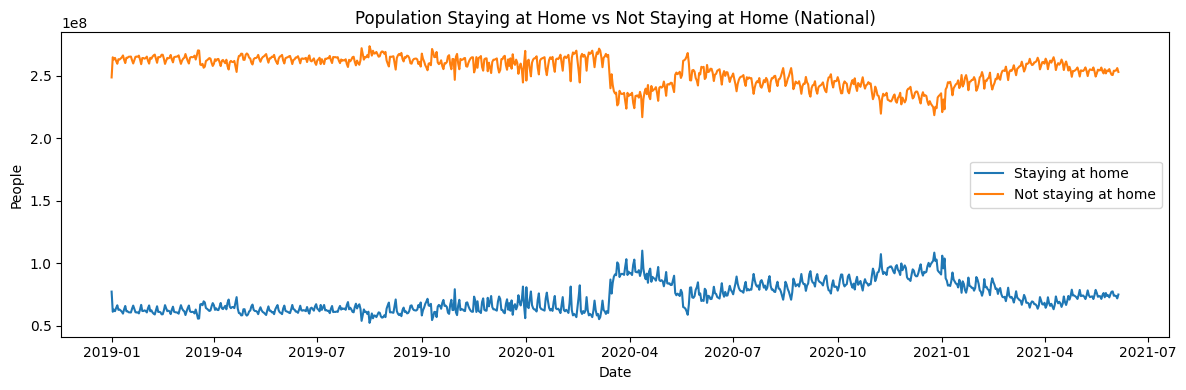

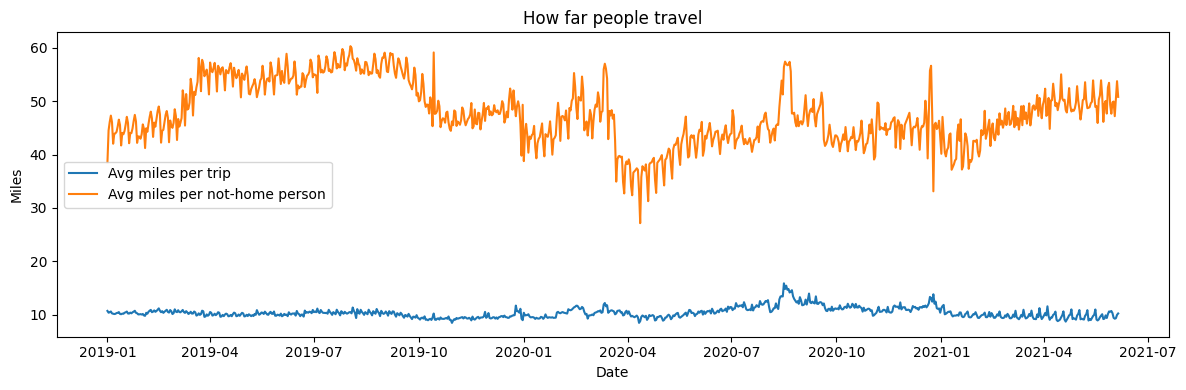

In [22]:
# A1) How many people are staying at home? (total + average daily)
home_stats = pd.DataFrame({
    "Metric": [
        "Total Staying at Home",
        "Total Not Staying at Home",
        "Average Daily Staying at Home",
        "Average Daily Not Staying at Home",
    ],
    "Value": [
        national_data["Population Staying at Home"].sum(),
        national_data["Population Not Staying at Home"].sum(),
        national_data["Population Staying at Home"].mean(),
        national_data["Population Not Staying at Home"].mean(),
    ],
})
display(home_stats)

# A2) How far are people traveling when they *don't* stay home?
# We have trips by distance bands; we compute:
#   - avg miles per trip
#   - avg miles per not-staying-home person
distance_midpoints = np.array([0.5, 2, 4, 7.5, 17.5, 37.5, 75, 175, 375, 500], dtype=float)

national_data["Total_Trips_by_Band"] = national_data[trip_columns].sum(axis=1)
national_data["Weighted_Miles"] = (national_data[trip_columns].values * distance_midpoints).sum(axis=1)

# Miles per trip
national_data["Avg_Miles_per_Trip"] = national_data["Weighted_Miles"] / national_data["Total_Trips_by_Band"].replace(0, np.nan)

# Miles per non-staying-home person
national_data["Avg_Miles_per_NotHome_Person"] = national_data["Weighted_Miles"] / national_data["Population Not Staying at Home"].replace(0, np.nan)

distance_stats = pd.DataFrame({
    "Metric": [
        "Average miles per trip (mean)",
        "Miles per trip (median)",
        "Miles per trip (min)",
        "Miles per trip (max)",
        "Average miles per person-not-home (mean)",
        "Miles per person-not-home (median)",
        "Miles per person-not-home (min)",
        "Miles per person-not-home (max)",
    ],
    "Value": [
        national_data["Avg_Miles_per_Trip"].mean(),
        national_data["Avg_Miles_per_Trip"].median(),
        national_data["Avg_Miles_per_Trip"].min(),
        national_data["Avg_Miles_per_Trip"].max(),
        national_data["Avg_Miles_per_NotHome_Person"].mean(),
        national_data["Avg_Miles_per_NotHome_Person"].median(),
        national_data["Avg_Miles_per_NotHome_Person"].min(),
        national_data["Avg_Miles_per_NotHome_Person"].max(),
    ],
})
display(distance_stats)

# View trends over time
daily = national_data.sort_values("Date")
plt.figure(figsize=(12,4))
plt.plot(daily["Date"], daily["Population Staying at Home"], label="Staying at home")
plt.plot(daily["Date"], daily["Population Not Staying at Home"], label="Not staying at home")
plt.title("Population Staying at Home vs Not Staying at Home (National)")
plt.xlabel("Date")
plt.ylabel("People")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(daily["Date"], daily["Avg_Miles_per_Trip"], label="Avg miles per trip")
plt.plot(daily["Date"], daily["Avg_Miles_per_NotHome_Person"], label="Avg miles per not-home person")
plt.title("How far people travel")
plt.xlabel("Date")
plt.ylabel("Miles")
plt.legend()
plt.tight_layout()
plt.show()


## 4) Requirement (b): identify dates meeting thresholds and compare them

Task:
- Dates where **> 10,000,000** for the **10–25** distance band
- Compare to dates where **> 10,000,000** for the **50–100** distance band


,Category,Number of dates
0,"10–25 band (>10,000,000)",887
1,"50–100 band (>10,000,000)",886
2,Overlap (both true),886



First 15 dates meeting 10–25 threshold:


,Date,Number of Trips 10-25
0,2019-01-01,116904343.0
1,2019-01-02,167412698.0
2,2019-01-03,172027487.0
3,2019-01-04,176144493.0
4,2019-01-05,165239790.0
5,2019-01-06,144091310.0
6,2019-01-07,165178406.0
7,2019-01-08,166322929.0
8,2019-01-09,166169173.0
9,2019-01-10,171169293.0



First 15 dates meeting 50–100 threshold:


,Date,Number of Trips 50-100
0,2019-01-01,15686639.0
1,2019-01-02,17739183.0
2,2019-01-03,18366626.0
3,2019-01-04,19315785.0
4,2019-01-05,19363939.0
5,2019-01-06,17418975.0
6,2019-01-07,17491604.0
7,2019-01-08,17369502.0
8,2019-01-09,17543261.0
9,2019-01-10,18087977.0



First 15 overlap dates:


,Date
0,2019-01-01
1,2019-01-02
2,2019-01-03
3,2019-01-04
4,2019-01-05
5,2019-01-06
6,2019-01-07
7,2019-01-08
8,2019-01-09
9,2019-01-10


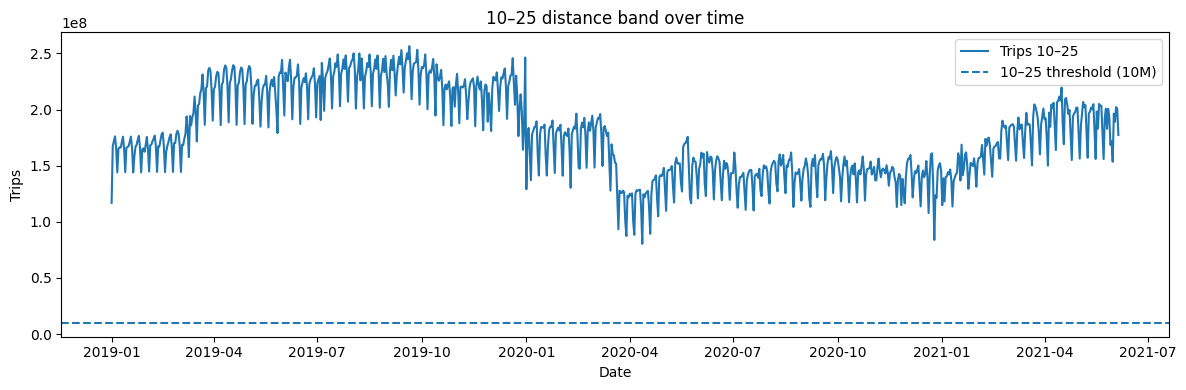

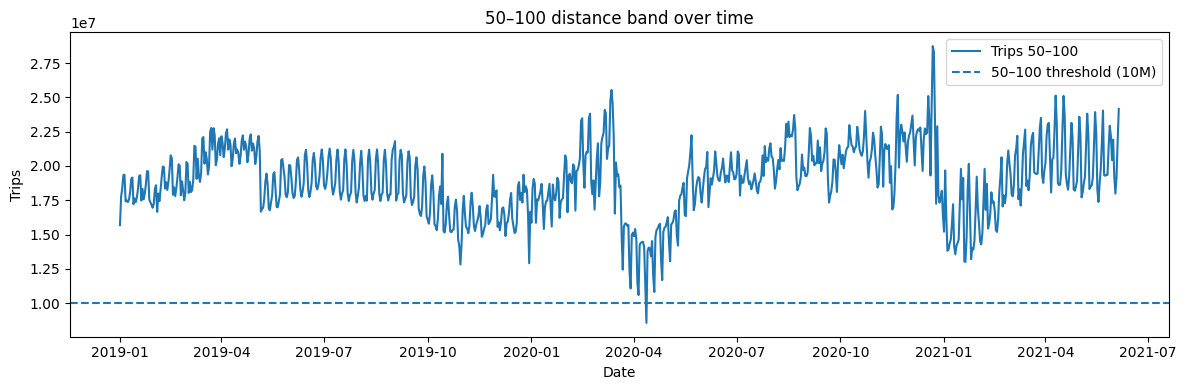

In [13]:
# Unified threshold for both distance bands
thr_10_25 = 10_000_000
thr_50_100 = 10_000_000

# Extract time series
series_10_25 = national_data[["Date", "Number of Trips 10-25"]].copy()
series_50_100 = national_data[["Date", "Number of Trips 50-100"]].copy()

# Filter dates exceeding threshold
dates_10_25 = series_10_25[series_10_25["Number of Trips 10-25"] > thr_10_25].sort_values("Date")
dates_50_100 = series_50_100[series_50_100["Number of Trips 50-100"] > thr_50_100].sort_values("Date")

# Overlap
set_10_25 = set(dates_10_25["Date"])
set_50_100 = set(dates_50_100["Date"])
overlap = sorted(set_10_25.intersection(set_50_100))

# Summary table
comparison_summary = pd.DataFrame({
    "Category": [
        "10–25 band (>10,000,000)",
        "50–100 band (>10,000,000)",
        "Overlap (both true)"
    ],
    "Number of dates": [
        len(dates_10_25),
        len(dates_50_100),
        len(overlap)
    ],
})

display(comparison_summary)

# Show first 15 qualified dates
print("\nFirst 15 dates meeting 10–25 threshold:")
display(dates_10_25.head(15))

print("\nFirst 15 dates meeting 50–100 threshold:")
display(dates_50_100.head(15))

print("\nFirst 15 overlap dates:")
display(pd.DataFrame({"Date": overlap}).head(15))

# ---- Visual comparison ----
plt.figure(figsize=(12,4))
plt.plot(series_10_25["Date"], series_10_25["Number of Trips 10-25"], label="Trips 10–25")
plt.axhline(thr_10_25, linestyle="--", label="10–25 threshold (10M)")
plt.title("10–25 distance band over time")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(series_50_100["Date"], series_50_100["Number of Trips 50-100"], label="Trips 50–100")
plt.axhline(thr_50_100, linestyle="--", label="50–100 threshold (10M)")
plt.title("50–100 distance band over time")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.tight_layout()
plt.show()


## 5) Requirement (c): sequential vs parallel processing (10 and 20 processors)

We aggregate by Date (sum). Measure wall-clock time for:
- sequential groupby
- parallel chunk+reduce with 10 processors
- parallel chunk+reduce with 20 processors


Sequential time: 0.0075s


,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips 10-25,Number of Trips 50-100,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
Date,,,,,,,,,,,,,,,
2019-01-01,77433867.0,248733553.0,8.977844e+08,116904343.0,15686639.0,241667151.0,234284795.0,108078903.0,129670778.0,116904343.0,40432062.0,15686639.0,7525563.0,1806022.0,1728112.0
2019-01-02,61305201.0,264862219.0,1.139452e+09,167412698.0,17739183.0,291276735.0,285887315.0,138039296.0,171637514.0,167412698.0,56148976.0,17739183.0,7817044.0,1962301.0,1531219.0
2019-01-03,63050480.0,263116940.0,1.162753e+09,172027487.0,18366626.0,296375014.0,290074425.0,140771581.0,175775410.0,172027487.0,57632422.0,18366626.0,8124548.0,2038099.0,1567072.0
2019-01-04,61803652.0,264363768.0,1.181954e+09,176144493.0,19315785.0,293159631.0,295643296.0,145251819.0,181324645.0,176144493.0,58761592.0,19315785.0,8687318.0,2096065.0,1569185.0
2019-01-05,64389745.0,261777675.0,1.180477e+09,165239790.0,19363939.0,295459014.0,304168709.0,148540651.0,180941769.0,165239790.0,54842134.0,19363939.0,8490791.0,1991159.0,1438664.0


Parallel time (10 workers): 0.0292s
Parallel time (20 workers): 0.0275s


,Method,Time (s),Speedup,Efficiency (%)
0,Sequential,0.007526,1.000000,100.000000
1,Parallel (10),0.029190,0.257823,2.578226
2,Parallel (20),0.027501,0.273656,1.368282


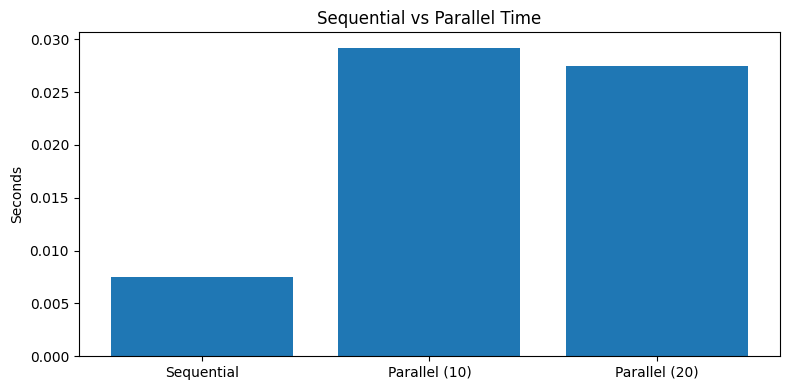

In [21]:
# 1) Sequential processing: group by Date
def process_sequential(data: pd.DataFrame) -> pd.DataFrame:
    return data.groupby("Date")[AGG_COLS].sum()

# 2) Processing a single chunk
def process_chunk(chunk: pd.DataFrame) -> pd.DataFrame:
    return chunk.groupby("Date")[AGG_COLS].sum()

# 3) Parallel processing: use joblib if available, otherwise fallback to multiprocessing.Pool
def parallel_process(data: pd.DataFrame, n_procs: int) -> tuple[pd.DataFrame, float]:
    # Limit number of workers
    n_procs = max(1, min(int(n_procs), cpu_count()))
    n_rows = len(data)
    if n_rows == 0:
        return pd.DataFrame(columns=AGG_COLS), 0.0
    # Split the dataset into chunks
    chunk_size = max(1, n_rows // n_procs)
    chunks = [data.iloc[i:i + chunk_size] for i in range(0, n_rows, chunk_size)]

    start = time.time()

    if _HAS_JOBLIB:
        # Parallel with joblib
        results = Parallel(n_jobs=n_procs, backend="loky")(
            delayed(process_chunk)(ch) for ch in chunks
        )
    else:
        # Fallback to multiprocessing.Pool
        with Pool(n_procs) as pool:
            results = pool.map(process_chunk, chunks)

    # Combine results and group again by Date
    final = (
        pd.concat(results)
        .groupby("Date")[AGG_COLS]
        .sum()
        .sort_index()
    )
    elapsed = time.time() - start
    return final, elapsed


# Run sequential, 10 workers, 20 workers

# Sequential time
t0 = time.time()
seq_result = process_sequential(national_data)
seq_time = time.time() - t0
print(f"Sequential time: {seq_time:.4f}s")
display(seq_result.head())

# Parallel times
par10_result, par10_time = parallel_process(national_data, 10)
par20_result, par20_time = parallel_process(national_data, 20)

print(f"Parallel time (10 workers): {par10_time:.4f}s")
print(f"Parallel time (20 workers): {par20_time:.4f}s")

# Speedup and efficiency

speedup_10 = seq_time / par10_time if par10_time > 0 else np.nan
speedup_20 = seq_time / par20_time if par20_time > 0 else np.nan
eff_10 = (speedup_10 / 10) * 100 if np.isfinite(speedup_10) else np.nan
eff_20 = (speedup_20 / 20) * 100 if np.isfinite(speedup_20) else np.nan

performance = pd.DataFrame({
    "Method": ["Sequential", "Parallel (10)", "Parallel (20)"],
    "Time (s)": [seq_time, par10_time, par20_time],
    "Speedup": [1.0, speedup_10, speedup_20],
    "Efficiency (%)": [100.0, eff_10, eff_20],
})

display(performance)

# Plot comparison

plt.figure(figsize=(8, 4))
plt.bar(performance["Method"], performance["Time (s)"])
plt.title("Sequential vs Parallel Time")
plt.ylabel("Seconds")
plt.tight_layout()
plt.show()

# If joblib was not available
if not _HAS_JOBLIB:
    print("NOTE: joblib not available; parallel section fell back to multiprocessing.Pool.")


## 6) Requirement (d): model to simulate travel frequency (considering trip length)

We define **travel frequency** as:
- `TripsPerNotHome = Total_Trips_by_Band / Population Not Staying at Home`

Features include trip-length composition (short/medium/long shares), average miles per trip,
and calendar features (day-of-week, month).

We then simulate typical travel frequency using a simple Poisson assumption:
- For a given day, per-person trip count ~ Poisson(λ = predicted TripsPerNotHome)


,Model,R2,RMSE,MAE
1,Random Forest,0.213629,0.508671,0.387034
0,Linear Regression,-0.045610,0.586554,0.506877


Best model: Random Forest


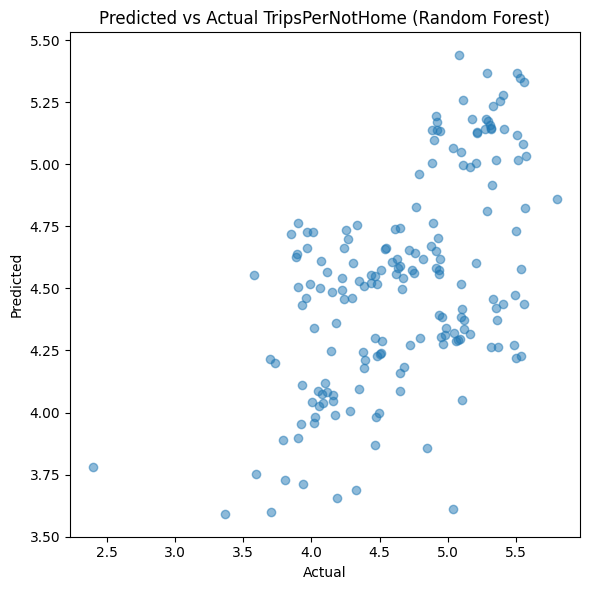

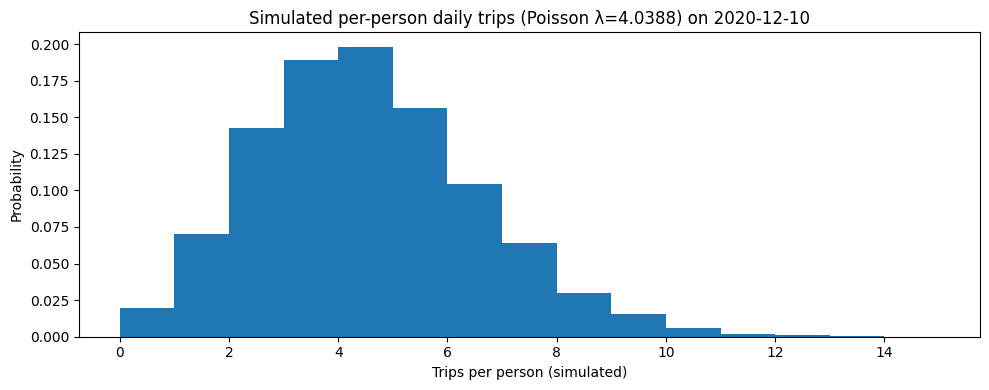

Simulated mean trips/person: 4.0547 (should be close to λ)


In [7]:
# Feature engineering: short/medium/long groupings
national_data["Short_Trips"] = national_data[["Number of Trips <1", "Number of Trips 1-3", "Number of Trips 3-5"]].sum(axis=1)
national_data["Medium_Trips"] = national_data[["Number of Trips 5-10", "Number of Trips 10-25", "Number of Trips 25-50"]].sum(axis=1)
national_data["Long_Trips"] = national_data[["Number of Trips 50-100", "Number of Trips 100-250", "Number of Trips 250-500", "Number of Trips >=500"]].sum(axis=1)

national_data["TripsPerNotHome"] = national_data["Total_Trips_by_Band"] / national_data["Population Not Staying at Home"].replace(0, np.nan)

# Shares by length
national_data["Short_Share"] = national_data["Short_Trips"] / national_data["Total_Trips_by_Band"].replace(0, np.nan)
national_data["Medium_Share"] = national_data["Medium_Trips"] / national_data["Total_Trips_by_Band"].replace(0, np.nan)
national_data["Long_Share"] = national_data["Long_Trips"] / national_data["Total_Trips_by_Band"].replace(0, np.nan)

# Calendar features
national_data["DOW"] = national_data["Date"].dt.dayofweek  # 0=Mon
national_data["Month"] = national_data["Date"].dt.month

model_df = national_data.dropna(subset=["TripsPerNotHome", "Avg_Miles_per_Trip", "Short_Share", "Medium_Share", "Long_Share"]).copy()
model_df = model_df.sort_values("Date")

X = model_df[["Avg_Miles_per_Trip", "Short_Share", "Medium_Share", "Long_Share", "DOW", "Month"]]
y = model_df["TripsPerNotHome"]

# Time-aware split: last 20% dates as test
split_idx = int(len(model_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

pred_lr = lr.predict(X_test)
pred_rf = rf.predict(X_test)

def metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAE": mean_absolute_error(y_true, y_pred),
    }

results = pd.DataFrame([
    {"Model": "Linear Regression", **metrics(y_test, pred_lr)},
    {"Model": "Random Forest", **metrics(y_test, pred_rf)},
]).sort_values("R2", ascending=False)

display(results)

best_name = results.iloc[0]["Model"]
best_model = rf if best_name == "Random Forest" else lr
best_pred = pred_rf if best_name == "Random Forest" else pred_lr
print("Best model:", best_name)

# Plot predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.5)
plt.title(f"Predicted vs Actual TripsPerNotHome ({best_name})")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()

# --- Simulation: per-person trip frequency for a specific test day ---
# Pick the first day in test set
test_day_idx = X_test.index[0]
test_row = X_test.loc[[test_day_idx]]
test_date = model_df.loc[test_day_idx, "Date"]

lam = float(best_model.predict(test_row)[0])
lam = max(lam, 0.0001)  # keep valid

# simulate per-person trip counts for N people
N = 10_000
sim_trips = np.random.poisson(lam=lam, size=N)

plt.figure(figsize=(10,4))
plt.hist(sim_trips, bins=range(0, max(15, sim_trips.max()+2)), density=True)
plt.title(f"Simulated per-person daily trips (Poisson λ={lam:.4f}) on {test_date.date()}")
plt.xlabel("Trips per person (simulated)")
plt.ylabel("Probability")
plt.tight_layout()
plt.show()

print(f"Simulated mean trips/person: {sim_trips.mean():.4f} (should be close to λ)")


## 7) Requirement (e): visualize participants (travellers) by distance–trips

The dataset provides **trips** by distance band, not explicit unique people per band.
To approximate “participants (travellers) per distance band”, we estimate:

`EstimatedParticipants_band = PopulationNotHome × (Trips_band / TotalTrips_by_Band)`

This assumes the likelihood a (not-staying-home) person is “represented” in a band is proportional to
the trip share in that band for the day. We show:
- trips by band (actual)
- estimated participants by band (proxy)


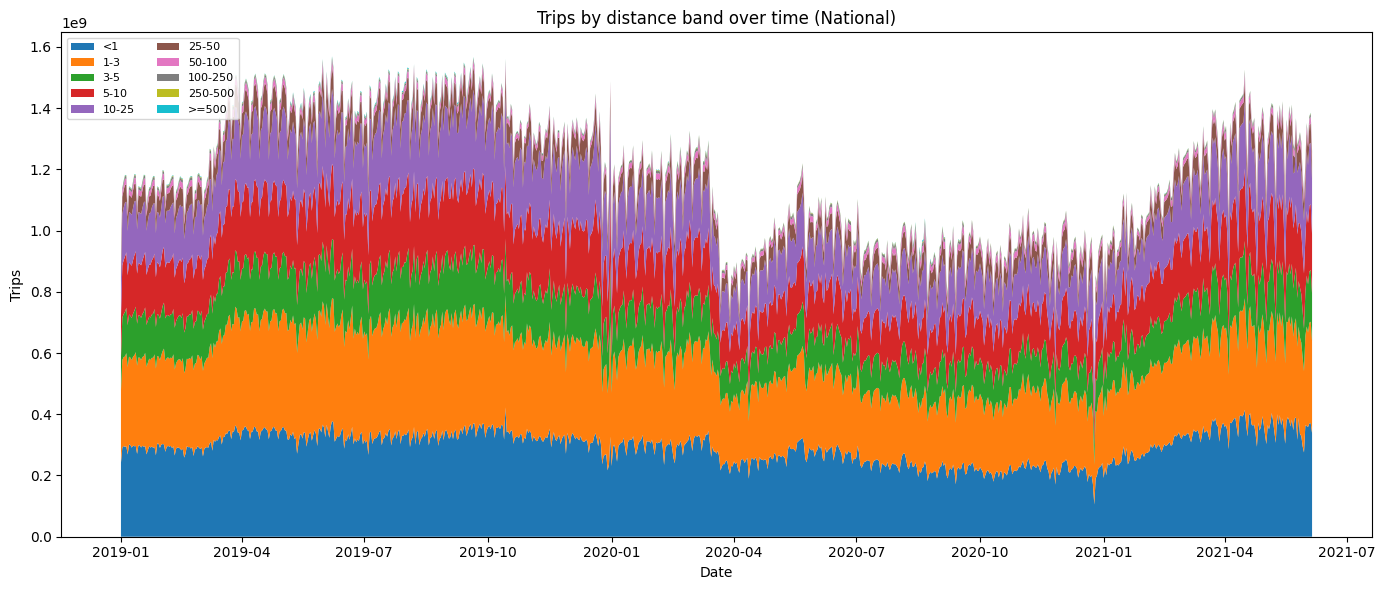

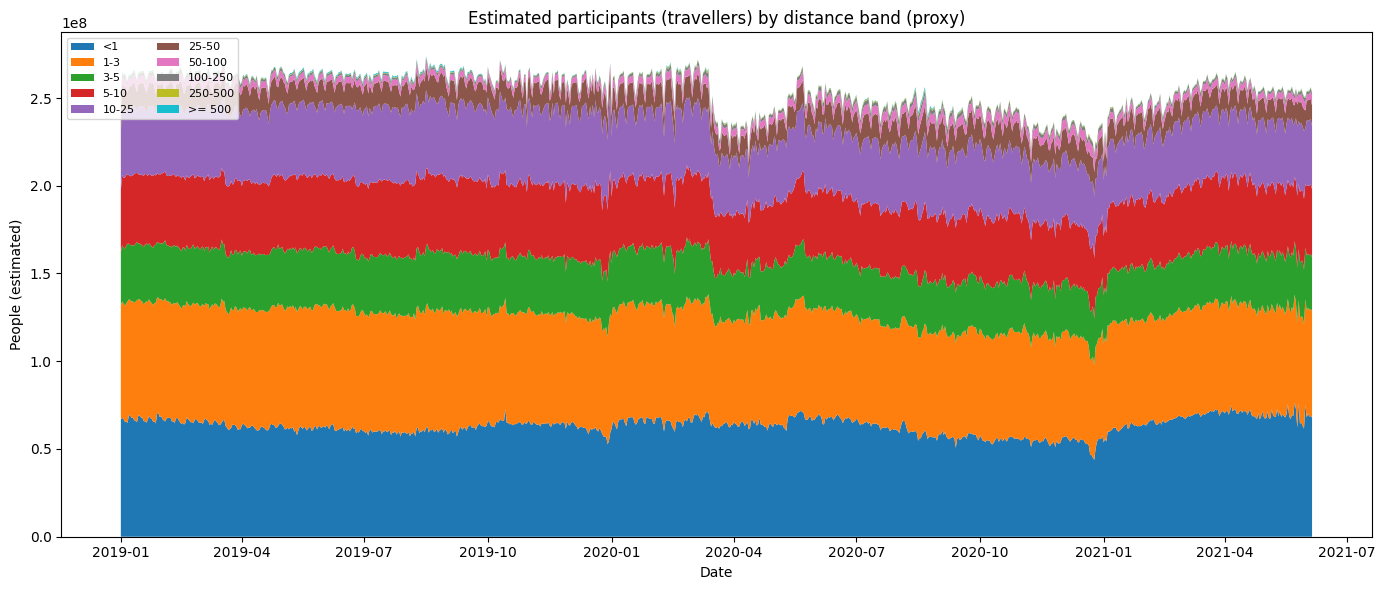

,Trip band,Total trips (all dates),Avg estimated participants/day
0,1-3,2.615449e+11,6.330312e+07
1,<1,2.603805e+11,6.302129e+07
2,5-10,1.622760e+11,3.927653e+07
3,10-25,1.586398e+11,3.839644e+07
4,3-5,1.285234e+11,3.110721e+07
5,25-50,5.137122e+10,1.243365e+07
6,50-100,1.680758e+10,4.068028e+06
7,100-250,6.910202e+09,1.672513e+06
8,250-500,1.535363e+09,3.716123e+05
9,>=500,1.269026e+09,3.071492e+05


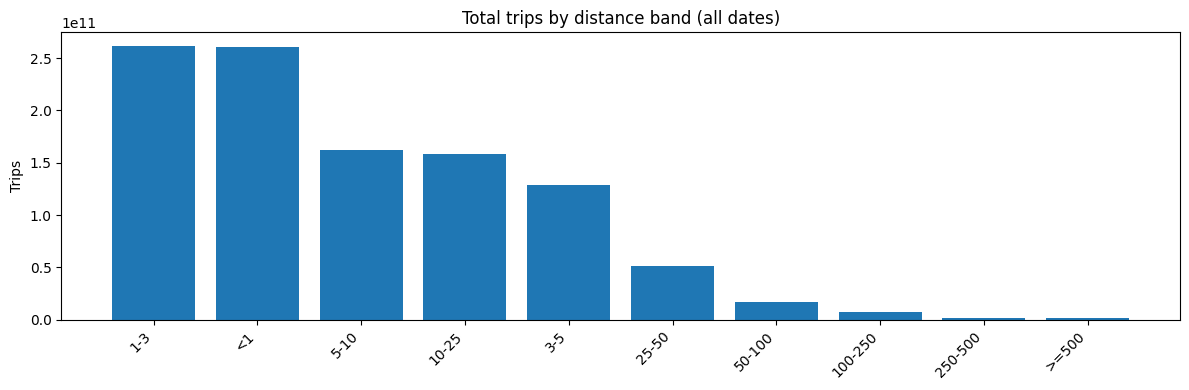

In [8]:
# Trips by band over time
band_df = national_data[["Date"] + trip_columns + ["Population Not Staying at Home", "Total_Trips_by_Band"]].copy().sort_values("Date")

# Actual trips stacked
plt.figure(figsize=(14,6))
plt.stackplot(
    band_df["Date"],
    [band_df[c].values for c in trip_columns],
    labels=[c.replace("Number of Trips ", "") for c in trip_columns],
)
plt.title("Trips by distance band over time (National)")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend(loc="upper left", ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# Estimated participants by band
for c in trip_columns:
    band_short = c.replace("Number of Trips ", "").replace(">=", ">= ")
    band_df[f"EstParticipants {band_short}"] = (
        band_df["Population Not Staying at Home"] * (band_df[c] / band_df["Total_Trips_by_Band"].replace(0, np.nan))
    )

est_cols = [c for c in band_df.columns if c.startswith("EstParticipants ")]
plt.figure(figsize=(14,6))
plt.stackplot(
    band_df["Date"],
    [band_df[c].values for c in est_cols],
    labels=[c.replace("EstParticipants ", "") for c in est_cols],
)
plt.title("Estimated participants (travellers) by distance band (proxy)")
plt.xlabel("Date")
plt.ylabel("People (estimated)")
plt.legend(loc="upper left", ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# Summaries: total trips by band + mean estimated participants by band
trip_totals = pd.Series({c: band_df[c].sum() for c in trip_columns}).sort_values(ascending=False)
est_means = pd.Series({c: band_df[c].mean() for c in est_cols}).sort_values(ascending=False)

summary = pd.DataFrame({
    "Trip band": trip_totals.index.str.replace("Number of Trips ", ""),
    "Total trips (all dates)": trip_totals.values,
    "Avg estimated participants/day": [
        band_df["Population Not Staying at Home"].mean() * (trip_totals[i] / trip_totals.sum())
        for i in trip_totals.index
    ],
})
display(summary.head(15))

plt.figure(figsize=(12,4))
plt.bar(summary["Trip band"], summary["Total trips (all dates)"])
plt.xticks(rotation=45, ha="right")
plt.title("Total trips by distance band (all dates)")
plt.ylabel("Trips")
plt.tight_layout()
plt.show()


## 8) Export key tables

In [9]:
performance.to_csv("processing_performance.csv", index=False)
results.to_csv("model_performance.csv", index=False)
home_stats.to_csv("home_stats.csv", index=False)
distance_stats.to_csv("distance_stats.csv", index=False)

print("Saved: processing_performance.csv, model_performance.csv, home_stats.csv, distance_stats.csv")


Saved: processing_performance.csv, model_performance.csv, home_stats.csv, distance_stats.csv
